## In-class hands-on activity: Regression Parts 3-4

### Real estate price prediction
主題: Ridge Regression, Lasso Regression, Bias-variance trade-off

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

In [55]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)
random.seed(1001)
np.random.seed(1001)  # Also set numpy random seed for reproducibility

# Configure Chinese font for matplotlib
try:
    # Try different Chinese fonts available on macOS
    chinese_fonts = ['PingFang SC', 'Heiti SC', 'STSong', 'STHeiti', 'Songti SC', 'Kaiti SC', 'Arial Unicode MS']
    import matplotlib.font_manager as fm
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    font_found = False
    for font in chinese_fonts:
        if font in available_fonts:
            matplotlib.rc('font', family=font)
            font_found = True
            print(f"Using Chinese font: {font}")
            break
    
    if not font_found:
        print("No Chinese fonts found, using default font with fallback")
        # Configure matplotlib to handle Chinese characters better
        matplotlib.rc('font', family='DejaVu Sans', size=10)
        plt.rcParams['axes.unicode_minus'] = False
        
except Exception as e:
    print(f"Font configuration error: {e}")
    matplotlib.rc('font', family='DejaVu Sans')

plt.rcParams['axes.unicode_minus'] = False  # Fix negative sign display

Using Chinese font: STHeiti


### 資料說明

* 包含新北市, 台北市, 高雄市, 桃園市, 台中市房價資料
* 單價: 新台幣/坪，經過線性轉換，只有相對大小有意義。
* 建物面積、車位面積、陽台面積、附屬建物面積經過線性轉換，只有相對大小有意義。
* 橫坐標、縱坐標經過平移處理。

注意: 原資料提供者為避免法律爭議而進行資料轉換。這件事在一般統計學習與機器學習專案中需審慎為之。務必了解資料轉換對專案目標的影響。

In [56]:
# training data
dftrain = pd.read_csv('./housing_5cities_train.csv')
# test data
dftesta = pd.read_csv('./housing_5cities_testa.csv')
print(f"Training df shape = {dftrain.shape}; test df shape = {dftesta.shape}")

Training df shape = (8140, 21); test df shape = (1031, 21)


In [57]:
# dftrain = dftrain.sample(frac = 0.1)
dftrain.shape

(8140, 21)

### Fit a ridge regression model;
Implement ridge regression closed form solution from scratch using numpy. You should not use existing ridge regression models in sklearn or other libraries to solve this question. 

Recall that the closed form solution for linear regression coefficient is:

$\hat{\beta} = (X^T X + \lambda I)^{-1} X^T y,$

where $\lambda$ is the regularization coefficient.

You may need to leverage the following methods:
* df.to_numpy
* numpy.linalg.inv or numpy.linalg.solve
* numpy.matmul or @
* numpy.ones
* numpy.hstack


In [58]:
# Utility functions
def gen_features(dftrain, dftest, numfeatures, catfeatures, enc):
    # Generate additional categorical features according to catfeatures
    # use enc to help you generate feature one-hot encoding. 
    # np.hstack will be useful here. 
    # Arrange numpy array such that numerical features go first, followed by categorical features
    # return the feature arrary for training and test data

    X_train = dftrain[numfeatures].to_numpy()    
    enc.fit(dftrain[catfeatures])
    X_train_cat = enc.transform(dftrain[catfeatures]).toarray()
    X_train2 = np.hstack((X_train, X_train_cat))

    X_test = dftesta[numfeatures].to_numpy()
    X_test_cat = enc.transform(dftesta[catfeatures]).toarray()
    X_test2 = np.hstack((X_test, X_test_cat))

    return X_train2, X_test2

def get_performance(X, y, beta):
    # Compute R2, RMSE, MAE, MAPE given X, y, and beta
    # return R2, RMSE, MAE, MAPE as a list
    
    y_mean = np.mean(y)
    SST = np.sum((y - y_mean) ** 2)
    # compute SSE
    c0 = np.ones((X.shape[0], 1))
    X = np.hstack((c0, X))  
    yhead = X @ beta
    error = yhead - y
    SSE = np.sum(error ** 2)
    MAE = np.mean(abs(error))
    RMSE = (np.mean(error ** 2)) ** 0.5
    MAPE = np.mean(abs(error / y))
    
    return 1 - SSE / SST, RMSE, MAE, MAPE

In [59]:
# TODO
def fit_ridge_reg(X_train, y_train, lam, reg_intercept = False):
    # implement the closed form solution for ridge regression
    # always include a constant term. 
    # However, if reg_intercept = False, do not include the constant term in regularization.
    # return the fitted coefficients
    # remember to add a column of ones first
    c0 = np.ones((X_train.shape[0], 1))
    X_with_intercept = np.hstack((c0, X_train))
    
    # Create regularization matrix
    lamI = np.eye(X_with_intercept.shape[1]) * lam
    if not reg_intercept:
        lamI[0, 0] = 0  # Don't regularize the intercept term
    
    # Compute the ridge regression solution: (X^T X + λI)^(-1) X^T y
    XTX = X_with_intercept.T @ X_with_intercept
    XTy = X_with_intercept.T @ y_train
    
    beta_head = np.linalg.solve(XTX + lamI, XTy)
    return beta_head
    # return np.zeros((X_train.shape[1]+1))

In [60]:
numfeatures = ['建物面積', '總樓層數', '屋齡']
catfeatures = ['縣市', '鄉鎮市區', '主要用途', '主要建材', '建物型態', '路名']
label = '單價'

y_train = dftrain[label].to_numpy()
y_test = dftesta[label].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
X_train, X_test = gen_features(dftrain, dftesta, numfeatures, catfeatures, enc)

lam = 0.0001
# lam = 1
beta_head = fit_ridge_reg(X_train, y_train, lam)

catnames = []
for a in enc.categories_:
    catnames.extend(list(a))
for c, (abeta, aname) in enumerate(zip(beta_head, ['Const.'] + numfeatures + catnames)):
    print(f"{aname}\t{abeta:.4f}")
    if c > 10: 
        print("... truncated ...")
        break

Const.	2.3136
建物面積	-0.0163
總樓層數	0.0038
屋齡	-0.0248
台中市	-0.4811
台北市	1.5733
新北市	0.0586
桃園市	-0.6371
高雄市	-0.5137
三峽區	-0.1519
三民區	0.0057
三重區	0.3037
... truncated ...


## Sanity Check
The cell output should be like:
<pre>
Const.	2.3142
建物面積	-0.0163
總樓層數	0.0038
屋齡	-0.0248
台中市	-0.4809
台北市	1.5735
新北市	0.0588
桃園市	-0.6368
高雄市	-0.5136
三峽區	-0.1520
三民區	0.0057
三重區	0.3036
... truncated ...
</pre>


In [61]:
# performance on training data
r2, RMSE, MAE, MAPE = get_performance(X_train, y_train, beta_head)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")


R2 = 0.9254
RMSE = 0.2755
MAE = 0.1687
MAPE = 0.0808


In [62]:
# performance on test data
r2, RMSE, MAE, MAPE = get_performance(X_test, y_test, beta_head)
print(f"R2 = {r2:.4f}")
print(f"RMSE = {RMSE:.4f}")
print(f"MAE = {MAE:.4f}")
print(f"MAPE = {MAPE:.4f}")

R2 = 0.8319
RMSE = 0.4294
MAE = 0.2487
MAPE = 0.1195


## Sanity Check
The cell output should be like:
<pre>
R2 = 0.8319
RMSE = 0.4294
MAE = 0.2487
MAPE = 0.1195
</pre>


In [63]:
# TODO

def ridge_perf_by_alphas(X_train, y_train, lamgrids, perfname = "MAPE"):
    # For each lambda in lamgrids, run fit_ridge_reg and compute training and test performance. 
    # Record the performance as indicated by perfname.
    # Return performance on training and test data as two one-dimensional numpy array
    
    perf_train = np.zeros((len(lamgrids), 4))
    perf_test = np.zeros((len(lamgrids), 4))
    # --- remove below ---
    for ii, agrid in enumerate(lamgrids):
        # if ii % 2 == 0: print(f"{ii}: lambda={agrid:.6f}")
        beta_head2 = fit_ridge_reg(X_train, y_train, agrid)
        r2, RMSE, MAE, MAPE = get_performance(X_train, y_train, beta_head2)
        r2_test, RMSE_test, MAE_test, MAPE_test = get_performance(X_test, y_test, beta_head2)
        
        if perfname == "MAPE":
            perf_train[ii, 0] = MAPE
            perf_test[ii, 0] = MAPE_test
        elif perfname == "MAE":
            perf_train[ii, 0] = MAE
            perf_test[ii, 0] = MAE_test
        elif perfname == "RMSE":
            perf_train[ii, 0] = RMSE
            perf_test[ii, 0] = RMSE_test
        elif perfname == "R2":
            perf_train[ii, 0] = r2
            perf_test[ii, 0] = r2_test
        else:
            raise(Exception(f"Unknown perfname {perfname}"))
        # if ii % 2 == 0: print(f"     MAPE = {MAPE_test:.4f}")
        
    return perf_train, perf_test
    # --- remove above ---

    # return np.zeros((len(lamgrids), 1)), np.zeros((len(lamgrids), 1))

In [64]:
lamgrids = np.geomspace(0.0001, 200, num=20)
perf_train, perf_test = ridge_perf_by_alphas(X_train, y_train, lamgrids, "MAPE")

tmpind = np.argmin(perf_test[:, 0])
best_lambda = lamgrids[tmpind]
best_mape_test = perf_test[tmpind, 0]
print(f"Best MAPE = {best_mape_test:.4f} at lambda = {best_lambda:.4f}")

Best MAPE = 0.1146 at lambda = 0.9541


### Sanity Check
The cell output should be like:
<pre>
Best MAPE = 0.1195 at lambda = 0.0002    
</pre>

[None]

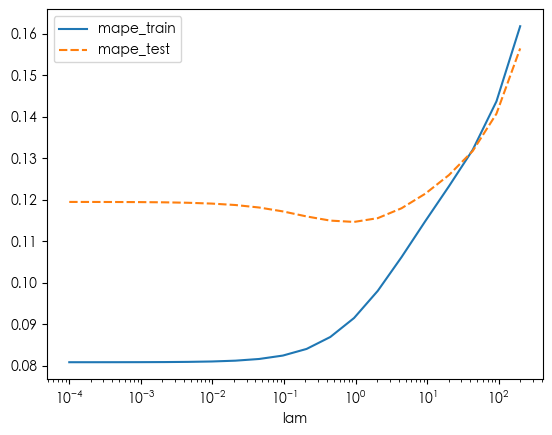

In [65]:
df_perf = pd.DataFrame({'lam': lamgrids,
                        "mape_train": perf_train[:,0],                        
                        "mape_test": perf_test[:,0]
                       })
df_perf = df_perf.set_index("lam")
p1 = sns.lineplot(data=df_perf[["mape_train", "mape_test"]])
p1.set(xscale='log')

### Below is the training and test MAPE using this dataset:
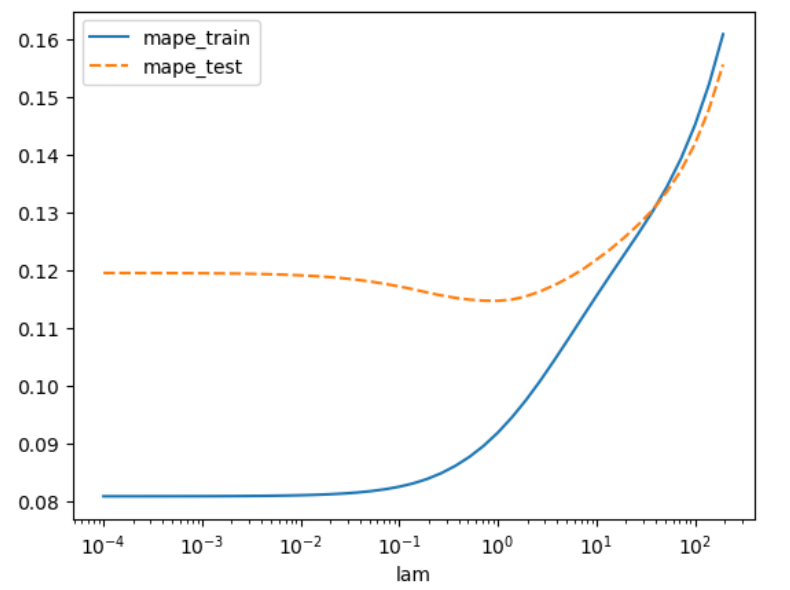

### Compare with what we have in slides:

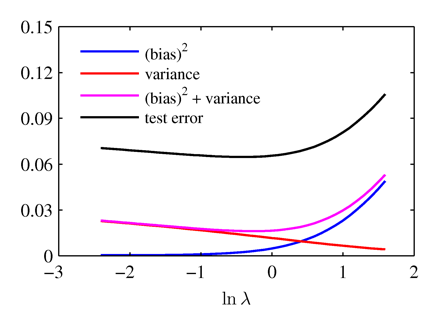

* Explain, in your words, why MAPE become larger when lambda is large?
* How close do you think these two picture are? Are they consistent?
* Why MAPE test is smaller compared to MAPE training when lambda is large?

---
## Lasso Regression

Lasso, Ridge, 與 Elastic-net是線性迴歸模型三兄弟，在各經典機器學習平台都有高品質實作。其中相當知名的是scikit-learn (<https://scikit-learn.org/stable/>)。

The Lasso user guide is here: <https://scikit-learn.org/stable/modules/linear_model.html#lasso>.


我們在這裡練習使用scikit-learn配適(Learn/Estimate/Fit) Lasso模型。

Topic covered:
* Leverage scikit-learn for model estimation. 
* Introduce the built-in CV approach.
* Hyperparameter tuning. 


In [66]:
# Start from data loading

# training data
dftrain = pd.read_csv('./housing_5cities_train.csv')
# test data
dftesta = pd.read_csv('./housing_5cities_testa.csv')
print(f"Training df shape = {dftrain.shape}; test df shape = {dftesta.shape}")

Training df shape = (8140, 21); test df shape = (1031, 21)


In [67]:
numfeatures = ['建物面積', '總樓層數', '屋齡']
catfeatures = ['縣市', '鄉鎮市區', '主要用途']
label = '單價'

y_train = dftrain[label].to_numpy()
y_test = dftesta[label].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
X_train, X_test = gen_features(dftrain, dftesta, numfeatures, catfeatures, enc)
print(f"Training df shape = {X_train.shape}; test df shape = {X_test.shape}")

catnames = []
for a in enc.categories_:
    catnames.extend(list(a))

# ['Const.'] +
# constant terms not included here
featnames =  numfeatures + catnames
print(f"First few features: {featnames[0:10]}...")

Training df shape = (8140, 97); test df shape = (1031, 97)
First few features: ['建物面積', '總樓層數', '屋齡', '台中市', '台北市', '新北市', '桃園市', '高雄市', '三峽區', '三民區']...


The loss function is: <br>
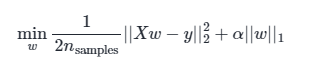

<span style="color:blue">
Note the weights of the two terms is $\frac{1}{2 N}$ and $\alpha$. This setting is slightly different from what we have in slides. Why?
</span>


In [68]:
# TODO
# create a lasso object with reglasso = linear_model.Lasso(...) and set alpha to 0.01.
# fit the training data and print out the constant term (intercept_) and the first 20 feature coefficients

# replace the line below
reglasso = linear_model.Lasso(alpha=0.01)
reglasso.fit(X_train, y_train)

if 'reglasso' in globals():
    print(f"Constant term coefficient: {reglasso.intercept_:.4f}")
    # only showing the first 20 coefficient.. (adjust by yourself as needed)
    for aname, acoef in zip(featnames, reglasso.coef_[0:20]):
        print(f"{aname}\t{acoef:.4f}")

Constant term coefficient: 1.4238
建物面積	0.0000
總樓層數	0.0179
屋齡	-0.0140
台中市	-0.0000
台北市	2.0132
新北市	0.5588
桃園市	-0.0480
高雄市	-0.1469
三峽區	-0.0000
三民區	-0.0000
三重區	0.0283
中區	-0.0000
中和區	0.0872
中壢區	-0.0000
中山區	0.0822
中正區	0.0339
五股區	-0.0000
仁武區	-0.0000
信義區	0.0789
內湖區	-0.0000


### Sanity Check
The cell output should be like:
<pre>
Constant term coefficient: 1.4238
建物面積	0.0000
總樓層數	0.0179
屋齡	-0.0140
台中市	-0.0000
台北市	2.0132
新北市	0.5588
桃園市	-0.0480
高雄市	-0.1469
三峽區	-0.0000
三民區	-0.0000
三重區	0.0283
中區	-0.0000
中和區	0.0872
中壢區	-0.0000
中山區	0.0822
中正區	0.0339
五股區	-0.0000
仁武區	-0.0000
信義區	0.0789
內湖區	-0.0000
</pre>

### The sklearn.metrics have implementations of many useful performance measures. Always reuse high-quality implementation whenever possible. (Except the case when we are in the process of learning new concepts and doing hands-on exercise)

In [69]:
if 'reglasso' in globals():
    yhead_train = reglasso.predict(X_train)
    yhead_test = reglasso.predict(X_test)
    
    r2_train = metrics.r2_score(y_train, yhead_train)
    rmse_train = metrics.root_mean_squared_error(y_train, yhead_train)
    mae_train = metrics.mean_absolute_error(y_train, yhead_train)
    mape_train = metrics.mean_absolute_percentage_error(y_train, yhead_train)
    
    print(f"R2 = {r2_train:.4f}")
    print(f"RMSE = {rmse_train:.4f}")
    print(f"MAE = {mae_train:.4f}")
    print(f"MAPE = {mape_train:.4f}")

R2 = 0.7471
RMSE = 0.5072
MAE = 0.3513
MAPE = 0.1793


In [70]:
if 'reglasso' in globals():
    r2_test = metrics.r2_score(y_test, yhead_test)
    rmse_test = metrics.root_mean_squared_error(y_test, yhead_test)
    mae_test = metrics.mean_absolute_error(y_test, yhead_test)
    mape_test = metrics.mean_absolute_percentage_error(y_test, yhead_test)
    
    print(f"R2 = {r2_test:.4f}")
    print(f"RMSE = {rmse_test:.4f}")
    print(f"MAE = {mae_test:.4f}")
    print(f"MAPE = {mape_test:.4f}")

R2 = 0.6745
RMSE = 0.5975
MAE = 0.3596
MAPE = 0.1761


In [71]:
# TODO
# uncomment lines below to run LassoCV

reglassocv = linear_model.LassoCV(alphas=np.logspace(-4, 4, 20))
reglassocv.fit(X_train, y_train)

if 'reglassocv' in globals():
    print(f"Best alpha is: {reglassocv.alpha_:.4f}")
    print(f"Best model intercept: {reglassocv.intercept_:.4f}")
    
    for aname, acoef in zip(featnames, reglassocv.coef_[0:20]):
        print(f"{aname}\t{acoef:.4f}")


    yhead_test = reglassocv.predict(X_test)

    r2_test = metrics.r2_score(y_test, yhead_test)
    rmse_test = metrics.root_mean_squared_error(y_test, yhead_test)
    mae_test = metrics.mean_absolute_error(y_test, yhead_test)
    mape_test = metrics.mean_absolute_percentage_error(y_test, yhead_test)
    
    print("Test performance:")
    print(f"R2 = {r2_test:.4f}")
    print(f"RMSE = {rmse_test:.4f}")
    print(f"MAE = {mae_test:.4f}")
    print(f"MAPE = {mape_test:.4f}")

Best alpha is: 0.0001
Best model intercept: 1.4505
建物面積	0.0072
總樓層數	0.0138
屋齡	-0.0215
台中市	-0.0000
台北市	2.0158
新北市	0.4533
桃園市	-0.1670
高雄市	-0.1413
三峽區	-0.0772
三民區	-0.0000
三重區	0.5150
中區	0.0000
中和區	0.5986
中壢區	0.1275
中山區	0.5832
中正區	0.8078
五股區	-0.2436
仁武區	-0.1126
信義區	0.7630
內湖區	-0.0588
Test performance:
R2 = 0.7586
RMSE = 0.5145
MAE = 0.2834
MAPE = 0.1340


## Elastic-net

We have introduced elastic-net in class. Elastic-net combines ridge and lasso to form a new model.

The loss is: <br>
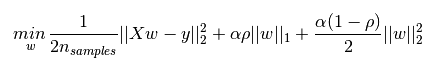

One interesting characteristics of Elastic-net is that we can compute the "whole coefficeint path." See below for the sample usage.

Computing regularization path using the elastic net...
The shape of coefs_enet is (97, 100)
Using Chinese font: STHeiti


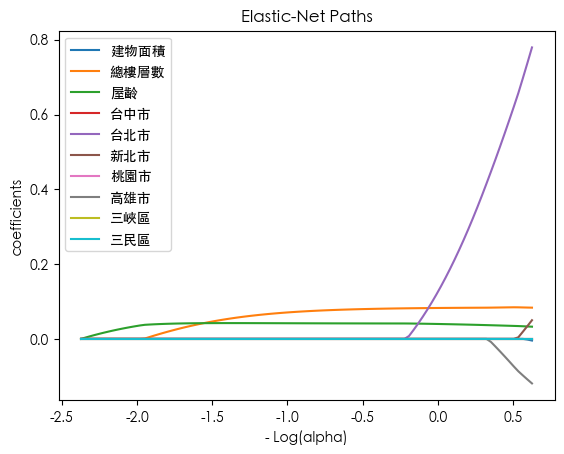

In [72]:
# TODO
# Uncomment the lines below to run the whole path of enet. Note the l1_ratio value.
# You can explore the effect of l1_ratio.


print("Computing regularization path using the elastic net...")
eps = 1e-3  # the smaller it is the longer is the path
alphas_enet, coefs_enet, _ = linear_model.enet_path(X_train, y_train, eps=eps, l1_ratio=0.2)
print(f"The shape of coefs_enet is {coefs_enet.shape}")

if 'alphas_enet' in globals():
    # if users indeed uncomments key lines
    # to fix Chinese character display issue
    # Use macOS compatible Chinese fonts
    try:
        # Try different Chinese fonts available on macOS
        chinese_fonts = ['PingFang SC', 'Heiti SC', 'STSong', 'STHeiti', 'Songti SC', 'Kaiti SC', 'Arial Unicode MS']
        import matplotlib.font_manager as fm
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        
        font_found = False
        for font in chinese_fonts:
            if font in available_fonts:
                matplotlib.rc('font', family=font)
                font_found = True
                print(f"Using Chinese font: {font}")
                break
        
        if not font_found:
            print("No Chinese fonts found, using default font")
            matplotlib.rc('font', family='DejaVu Sans')
    except:
        matplotlib.rc('font', family='DejaVu Sans')
    
    plt.rc('axes', unicode_minus=False)
    plt.figure()
    
    # only plot the first 10 variables (not to clutter the picture)
    coefs_enet_sub = coefs_enet[0:10, :]
    l1 = plt.plot(-np.log10(alphas_enet), coefs_enet_sub.T)
    
    plt.xlabel('- Log(alpha)')
    plt.ylabel('coefficients')
    plt.title('Elastic-Net Paths')
    plt.legend(featnames[0:10])